# Counterfactual explanations

In [1]:
import trustyai
trustyai.init()

import pandas as pd

## Simple example

We start by defining our black-box model, typically represented by

$$
f(\mathbf{x}) = \mathbf{y}
$$

Where $\mathbf{x}=\{x_1, x_2, \dots,x_m\}$ and $\mathbf{y}=\{y_1, y_2, \dots,y_n\}$.

Our example toy model, in this case, takes an all-numerical input $\mathbf{x}$ and return a $\mathbf{y}$ of either `true` or `false` if the sum of the $\mathbf{x}$ components is within a threshold $\epsilon$ of a point $\mathbf{C}$, that is:

$$
f(\mathbf{x}, \epsilon, \mathbf{C})=\begin{cases}
\text{true},\qquad \text{if}\ \mathbf{C}-\epsilon<\sum_{i=1}^m x_i <\mathbf{C}+\epsilon \\
\text{false},\qquad \text{otherwise}
\end{cases}
$$

This model is provided in the `TestUtils` module. We instantiate with a $\mathbf{C}=500$ and $\epsilon=1.0$.

In [2]:
from trustyai.utils import TestUtils

center = 500.0
epsilon = 1.0

model = TestUtils.getSumThresholdModel(center, epsilon)

Next we need to define a **goal**.
If our model is $f(\mathbf{x'})=\mathbf{y'}$ we are then defining our $\mathbf{y'}$ and the counterfactual result will be the $\mathbf{x'}$ which satisfies $f(\mathbf{x'})=\mathbf{y'}$.

We will define our goal as `true`, that is, the sum is withing the vicinity of a (to be defined) point $\mathbf{C}$. The goal is a list of `Output` which take the following parameters

- The feature name
- The feature type
- The feature value (wrapped in `Value`)
- A confidence threshold, which we will leave at zero (no threshold)

In [3]:
from trustyai.model import output

goal = [output(name="inside", dtype="bool", value=True)]

We will now define our initial features, $\mathbf{x}$. Each feature can be instantiated by using `FeatureFactory` and in this case we want to use numerical features, so we'll use `FeatureFactory.newNumericalFeature`.

Finally, we also specify which are the **bounds** for the counterfactual search. Typically this can be set either using domain-specific knowledge or taken from the data. In this case we simply specify an arbitrary (sensible) value, e.g. all the features can vary between `0` and `1000`.

In [4]:
import random
from trustyai.model import feature

features = [
    feature(name=f"x{i+1}", value=random.random() * 10.0, dtype="number", domain=(0.0, 1000.0))
    for i in range(4)
]

As we can see, the sum of of the features will not be within $\epsilon$ (1.0) of $\mathbf{C}$ (500.0). As such the model prediction will be `false`:

In [5]:
feature_sum = 0.0
for f in features:
    value = f.value.as_number()
    print(f"Feature {f.name} has value {value}")
    feature_sum += value
print(f"\nFeatures sum is {feature_sum}")

Feature x1 has value 0.15365275267992695
Feature x2 has value 7.94437414740824
Feature x3 has value 9.081839889637104
Feature x4 has value 3.603906618277297

Features sum is 20.783773408002567


We can now instantiate the **explainer** itself.

To do so, we will to configure the termination criteria. For this example we will specify that the counterfactual search should only execute a maximum of 10,000 iterations before stopping and returning whatever the best result is so far.

We can can now instantiate the explainer itself using `CounterfactualExplainer`.

In [6]:
from trustyai.explainers import CounterfactualExplainer

explainer = CounterfactualExplainer(steps=10_000)

SLF4J: Failed to load class "org.slf4j.impl.StaticLoggerBinder".
SLF4J: Defaulting to no-operation (NOP) logger implementation
SLF4J: See http://www.slf4j.org/codes.html#StaticLoggerBinder for further details.


We will now express the counterfactual problem as defined above.

- `input` represents our $\mathbf{x}$ which know gives a prediction of `False`
- `outputs` represents our $\mathbf{y'}$, that is our desired prediction (`True`)
- `domain` repreents the boundaries for the counterfactual search

We wrap these quantities in a `CounterfactualPrediction` (the UUID is simply to label the search instance):

In [7]:
from trustyai.model import counterfactual_prediction

prediction = counterfactual_prediction(
    input_features=features,
    outputs=goal)

We now request the counterfactual $\mathbf{x'}$ which is closest to $\mathbf{x}$ and which satisfies $f(\mathbf{x'}, \epsilon, \mathbf{C})=\mathbf{y'}$:

In [8]:
explanation = explainer.explain(prediction, model)

We can see that the counterfactual $\mathbf{x'}$

In [9]:
df = explanation.as_dataframe()
display(df)
print(f"\nFeature sum is {df.proposed.sum()}")

,features,proposed,original,constrained,difference
0,x1,0.153653,0.153653,False,0.000000
1,x2,486.357083,7.944374,False,478.412709
2,x3,9.291427,9.081840,False,0.209587
3,x4,3.603907,3.603907,False,0.000000



Feature sum is 499.40606904575867


In [10]:
df.to_html(classes='table table-striped text-center', justify='center').replace("\n","")

'<table border="1" class="dataframe table table-striped text-center">  <thead>    <tr style="text-align: center;">      <th></th>      <th>features</th>      <th>proposed</th>      <th>original</th>      <th>constrained</th>      <th>difference</th>    </tr>  </thead>  <tbody>    <tr>      <th>0</th>      <td>x1</td>      <td>0.153653</td>      <td>0.153653</td>      <td>False</td>      <td>0.000000</td>    </tr>    <tr>      <th>1</th>      <td>x2</td>      <td>486.357083</td>      <td>7.944374</td>      <td>False</td>      <td>478.412709</td>    </tr>    <tr>      <th>2</th>      <td>x3</td>      <td>9.291427</td>      <td>9.081840</td>      <td>False</td>      <td>0.209587</td>    </tr>    <tr>      <th>3</th>      <td>x4</td>      <td>3.603907</td>      <td>3.603907</td>      <td>False</td>      <td>0.000000</td>    </tr>  </tbody></table>'

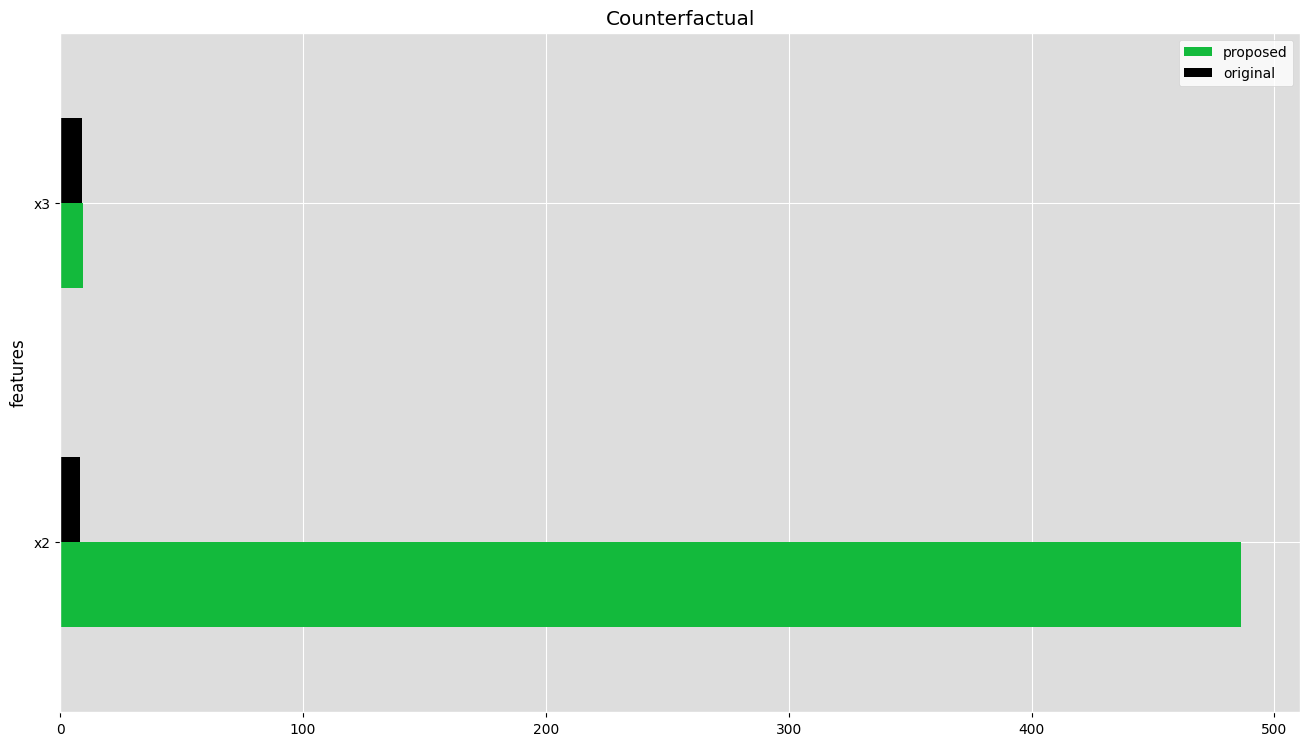

In [11]:
explanation.plot()

### Constrained features

As we've seen, it is possible to constraint a specific feature $x_i$ by setting the _constraints_ list corresponding element to `True`.

In this example, we know want to fix $x_1$ and $x_4$. That is, these features should have the same value in the counterfactual $\mathbf{x'}$ as in the original $\mathbf{x}$.

By simply **omitting a search domain** to a feature we are constraining it.

In [12]:
features = [
    feature(name=f"x1", value=random.random() * 10.0, dtype="number"),
    feature(name=f"x2", value=random.random() * 10.0, dtype="number", domain=(0.0, 1000.0)),
    feature(name=f"x3", value=random.random() * 10.0, dtype="number", domain=(0.0, 1000.0)),
    feature(name=f"x4", value=random.random() * 10.0, dtype="number"),
]

We simply need to wrap the previous quantities with the new constraints:

In [13]:
prediction = counterfactual_prediction(
    input_features=features, 
    outputs=goal)

And request a new counterfactual explanation

In [14]:
explanation = explainer.explain(prediction, model)

We can see that $x_1$ and $x_4$ has the same value as the original and the model satisfies the conditions.

In [15]:
explanation.as_dataframe()

,features,proposed,original,constrained,difference
0,x1,3.196913,3.196913,True,0.000000
1,x2,4.043419,3.651740,False,0.391679
2,x3,488.033037,9.766968,False,478.266069
3,x4,4.119719,4.119719,True,0.000000


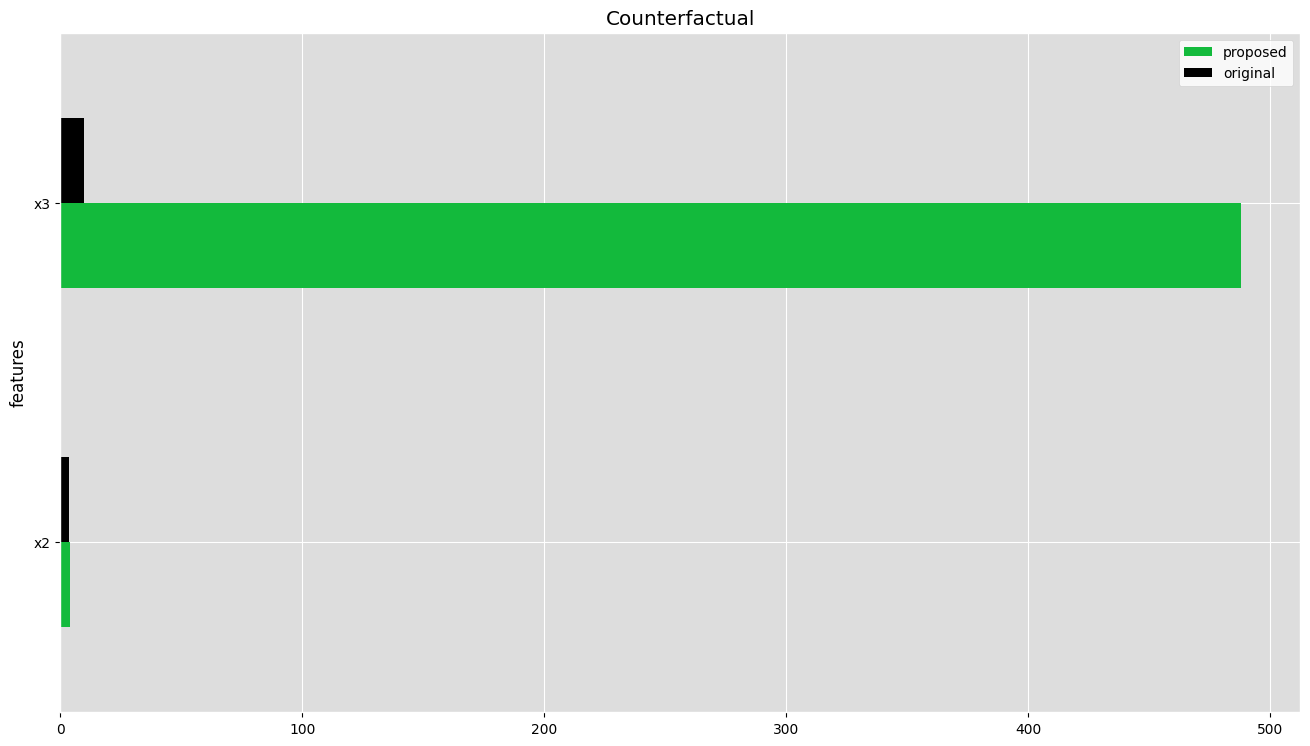

In [16]:
explanation.plot()

## Using Python models



We will now show how to use a custom Python model with TrustyAI counterfactual explanations.

The model will be an [XGBoost](https://github.com/dmlc/xgboost) one trained with the `credit-bias` dataset (available [here](https://github.com/ruivieira/benchmark-models/tree/main/credit-bias)).

For convenience, the model is pre-trained and serialised with `joblib` so that for this example we simply need to deserialised it.

In [17]:
import joblib

xg_model = joblib.load("models/credit-bias-xgboost.joblib")
print(xg_model)

/usr/local/lib/python3.9/site-packages/xgboost/compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.07, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=12, num_parallel_tree=1, random_state=27,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=0.9861206227457426,
              seed=27, subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)


This model has as a single **output** a boolean `PaidLoan`, which will predict whether a certain loan applicant will repay the loan in time or not. The model is slightly more complex than the previous examples, with **input** features:

|Input feature         | Type    | Note        |
|----------------------|---------|-------------|
|`NewCreditCustomer`   |boolean  ||
|`Amount`              |numerical||
|`Interest`            |numerical||
|`LoanDuration`        |numerical|In months|
|`Education`           |numerical|Level (1, 2, 3..)|
|`NrOfDependants`      |numerical|Integer|
|`EmploymentDurationCurrentEmployer`|numerical|Integer (years)|
|`IncomeFromPrincipalEmployer`|numerical||
|`IncomeFromPension`   |numerical||
|`IncomeFromFamilyAllowance`|numerical||
|`IncomeFromSocialWelfare`|numerical||
|`IncomeFromLeavePay`|numerical||
|`IncomeFromChildSupport`|numerical||
|`IncomeOther`|numerical||
|`ExistingLiabilities`|numerical|integer|
|`RefinanceLiabilities`|numerical|integer|
|`DebtToIncome`|numerical||
|`FreeCash`|numerical||
|`CreditScoreEeMini`|numerical|integer|
|`NoOfPreviousLoansBeforeLoan`|numerical|integer|
|`AmountOfPreviousLoansBeforeLoan`|numerical||
|`PreviousRepaymentsBeforeLoan`|numerical||
|`PreviousEarlyRepaymentsBefoleLoan`|numerical||
|`PreviousEarlyRepaymentsCountBeforeLoan`|numerical|integer|
|`Council_house`|boolean||
|`Homeless`|boolean||
|`Joint_ownership`|boolean||
|`Joint_tenant`|boolean||
|`Living_with_parents`|boolean||
|`Mortgage`|boolean||
|`Other`|boolean||
|`Owner`|boolean||
|`Owner_with_encumbrance`|boolean||
|`Tenant`|boolean||
|`Entrepreneur`|boolean||
|`Fully`|boolean||
|`Partially`|boolean||
|`Retiree`|boolean||
|`Self_employed`|boolean||

We will start by testing the model with an input we are quite sure (from the original data) that will be predicted as `false`:

In [18]:
feature_values = {
        "NewCreditCustomer": False,
        "Amount": 2125.0,
        "Interest": 20.97,
        "LoanDuration": 60.0,
        "Education": 4.0,
        "NrOfDependants": 0.0,
        "EmploymentDurationCurrentEmployer": 6.0,
        "IncomeFromPrincipalEmployer": 0.0,
        "IncomeFromPension": 301.0,
        "IncomeFromFamilyAllowance": 0.0,
        "IncomeFromSocialWelfare": 53.0,
        "IncomeFromLeavePay": 0.0,
        "IncomeFromChildSupport": 0.0,
        "IncomeOther": 0.0,
        "ExistingLiabilities": 8.0,
        "RefinanceLiabilities": 6.0,
        "DebtToIncome": 26.29,
        "FreeCash": 10.92,
        "CreditScoreEeMini": 1000.0,
        "NoOfPreviousLoansBeforeLoan": 1.0,
        "AmountOfPreviousLoansBeforeLoan": 500.0,
        "PreviousRepaymentsBeforeLoan": 590.95,
        "PreviousEarlyRepaymentsBefoleLoan": 0.0,
        "PreviousEarlyRepaymentsCountBeforeLoan": 0.0,
        "Council_house": False,
        "Homeless": False,
        "Joint_ownership": False,
        "Joint_tenant": False,
        "Living_with_parents": False,
        "Mortgage": False,
        "Other": False,
        "Owner": False,
        "Owner_with_encumbrance": True,
        "Tenant": True,
        "Entrepreneur": False,
        "Fully": False,
        "Partially": False,
        "Retiree": True,
        "Self_employed": False
}

feature_df = pd.DataFrame([feature_values])
feature_df

,NewCreditCustomer,Amount,Interest,LoanDuration,Education,NrOfDependants,EmploymentDurationCurrentEmployer,IncomeFromPrincipalEmployer,IncomeFromPension,IncomeFromFamilyAllowance,...,Mortgage,Other,Owner,Owner_with_encumbrance,Tenant,Entrepreneur,Fully,Partially,Retiree,Self_employed
0,False,2125.0,20.97,60.0,4.0,0.0,6.0,0.0,301.0,0.0,...,False,False,False,True,True,False,False,False,True,False


We can confirm now that this input will lead to a `false` `PaidLoan` prediction with a probability of $\sim77\%$:

In [19]:
print(xg_model.predict_proba(feature_df))
print(f"Paid loan is predicted as: {xg_model.predict(feature_df)}")

[[0.7835957  0.21640435]]
Paid loan is predicted as: [False]


We will now prepare the XGBoost model to be used from the TrustyAI counterfactual engine.

To do so, we simply need to wrap the `predict` function into a `TrustyAI.Model`class. Since our model outputs a Numpy array, we need to specify the column names of the output, so we can later use those names to set the goals of our counterfactual search.

In [20]:
from trustyai.model import Model

model = Model(xg_model.predict, output_names=['PaidLoan'])

### Unconstrained basic search

To get started we will search for a counterfactual with no constraints at all. This is not a realistic use case, but we will use it as a baseline.

We will also create a set of equal bounds for all the features. Again, this is not realistic, but we do it to establish a baseline. 

In [21]:
from trustyai.model.domain import feature_domain
features = []
for k,v in  feature_df.iloc[0].items():
    if type(v) is bool:
        features.append(feature(k, "bool", v,  domain=(true, false)))
    else:
        features.append(feature(k, "number", v,  domain=(0, 10000.)))

We want our **goal** to be the model predicting the loan will be paid (`PaidLoad=true`), so we specify it as:

In [22]:
goal = [output(name="PaidLoan", dtype="bool", value=True)]

We now wrap all this context in a `CounterfactualPrediction` object

In [23]:
prediction = counterfactual_prediction(
    input_features=features, 
    outputs=goal)

We are now ready to search for a counterfactual:

In [24]:
from trustyai.explainers import CounterfactualExplainer

explainer = CounterfactualExplainer(steps=10_000)
explanation = explainer.explain(prediction, model)

First we will confirm that our counterfactual changes the outcome, by predicting its outcome using the model:

In [25]:
model(explanation.proposed_features_dataframe)

array([ True])

And indeed it changes. We will now verify _which_ features were changed:

In [26]:
df = explanation.as_dataframe()
df[df.difference != 0.0]

,features,proposed,original,constrained,difference
1,Amount,2124.307321,2125.0,False,-0.692679
15,RefinanceLiabilities,0.000000,6.0,False,-6.000000
23,PreviousEarlyRepaymentsCountBeforeLoan,6.000000,0.0,False,6.000000


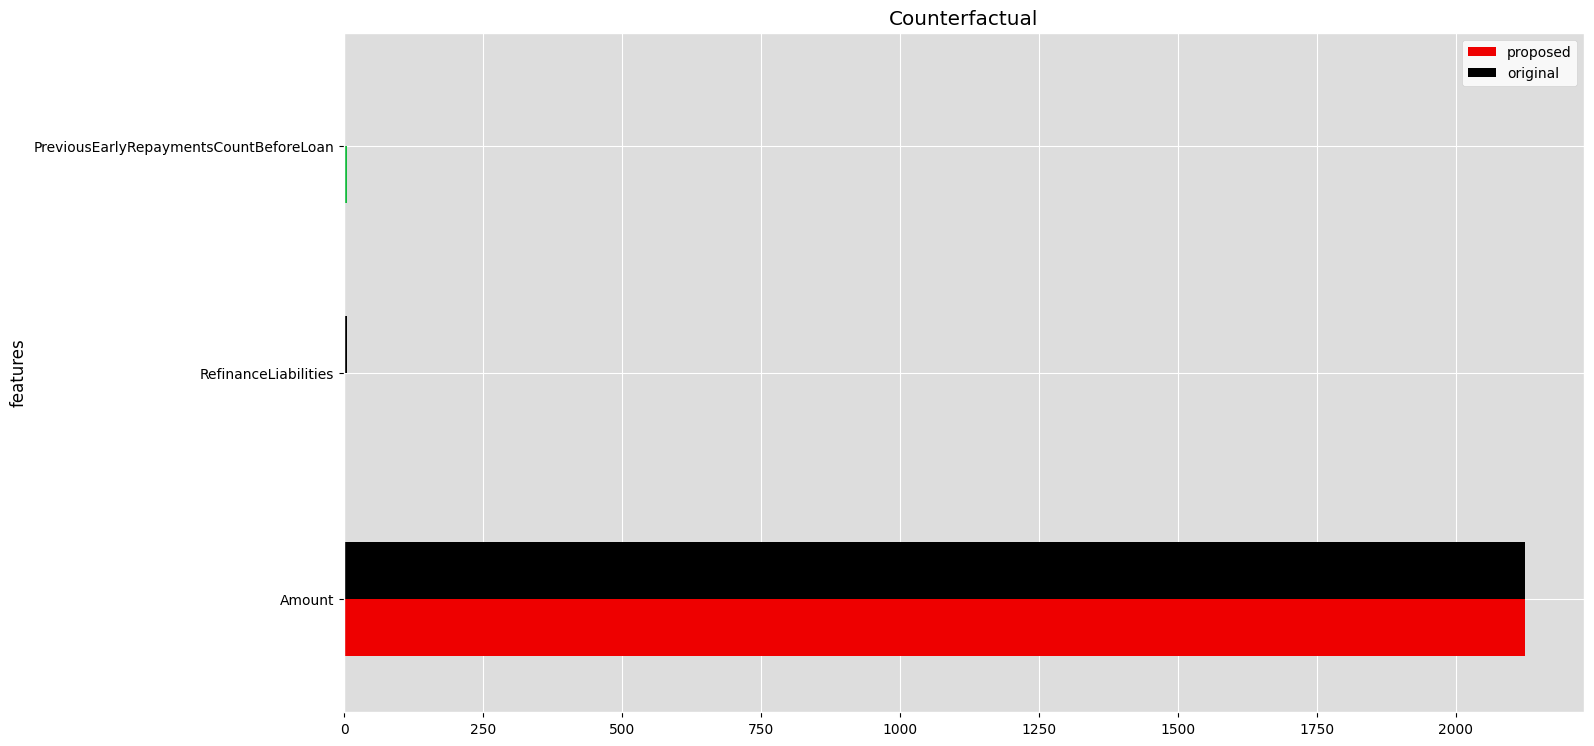

In [27]:
explanation.plot()

Here we can see the problem with the unconstrained search.

Some of the fields that were changed (_e.g._ `IncomeFromSocialWelfare`, `RefinanceLiabilities`, etc) might be difficult to change in practice.

### Constrained search

We will now try a more realistic search, which incorporates domain specific knowledge (and common sence).

To do so, we will constrain features we feel they shouldn't (or mustn't) change and specify sensible search bounds.
We will start with the constraints:

The constraints should be self-explanatory, but in essence they were divided into three groups

- Attributes you **cannot** or **should** not change (protected), for instance age, education level, etc
- Attributes you **can** change, for loan duration, loan amount, etc
- Attributes you probably won't be able to change, but might be informative to change. For instance, you might not be able to easily change your income, but you might be interested in how much would it need to be in order to get the prediction as favourable.

In [28]:
domains = {
        "Amount": (0.0, 1000.0),
        "LoanDuration": (0.0, 120.0),
        "EmploymentDurationCurrentEmployer": (0.0, 40.0),
        "IncomeFromPrincipalEmployer": (0.0, 1000.0),
        "IncomeFromPension": (0.0, 1000.0),
        "IncomeFromFamilyAllowance": (0.0, 1000.0),
        "IncomeFromSocialWelfare": (0.0, 1000.0),
        "IncomeFromLeavePay": (0.0, 1000.0),
        "IncomeFromChildSupport": (0.0, 1000.0),
        "IncomeOther": (0.0, 1000.0),
        "DebtToIncome": (0.0, 100.0),
        "FreeCash": (0.0, 100.0),
        "CreditScoreEeMini": (0.0, 10000.0)
}

features = [feature(k, "number" if type(v) is float else "bool", v, domains.get(k)) for k,v in feature_values.items()]

As before, we wrap this data in a `CounterfactualPrediction`:

In [29]:
prediction = counterfactual_prediction(
    input_features=features,
    outputs=goal
)

And we start a new search:

In [30]:
explanation = explainer.explain(prediction, model)

We test that the counterfactual does change the outcome:

In [31]:
model(explanation.proposed_features_dataframe)

array([ True])

And we confirm that no constrained features were changed:

In [32]:
df = explanation.as_dataframe()
df[df.difference != 0.0]

,features,proposed,original,constrained,difference
3,LoanDuration,56.719125,60.0,False,-3.280875
10,IncomeFromSocialWelfare,60.000000,53.0,False,7.000000


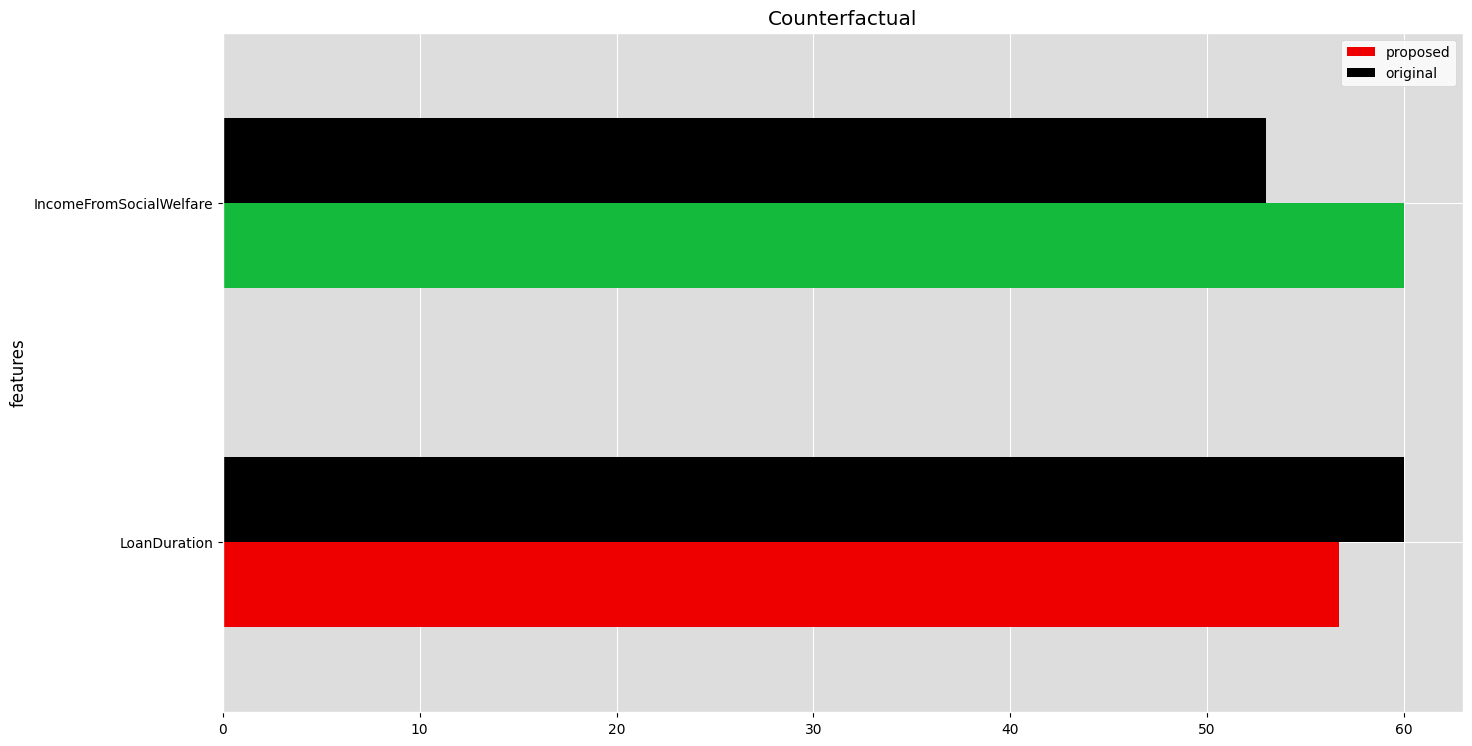

In [33]:
explanation.plot()

### Minimum counterfactual probabilities

We can see that the previous answer is very close to $50\%$.

With TrustyAI we have the possibility to specify a minimum probability for the result (when the model supports prediction confidences).

Let's say we want a result that is at least $75\%$ confident that the loan will be repaid. We can just encode the **minimum probability** as the last argument of each `Output`. A minimum probability of $0$ (as we've used) simply means that any desired outcome will be accepted, regardless of its probability. 

In [34]:
model = Model(lambda x: xg_model.predict_proba(x)[:,1], output_names=["Probability"])
goal = [output(name="True Probability", dtype="number", value=.75)]

We can then re-run the search with all the data as defined previously:

In [35]:
prediction = counterfactual_prediction(
    input_features=features,
    outputs=goal
)

In [36]:
explanation = explainer.explain(prediction, model)

As previously, we check that the answer is what we are looking for:

In [37]:
model(explanation.proposed_features_array)

array([0.7572675], dtype=float32)

And we show which features need to be changed for said desired outcome:

In [38]:
df = explanation.as_dataframe()
df[df.difference != 0.0]

,features,proposed,original,constrained,difference
3,LoanDuration,14.604508,60.00,False,-45.395492
17,FreeCash,10.965166,10.92,False,0.045166


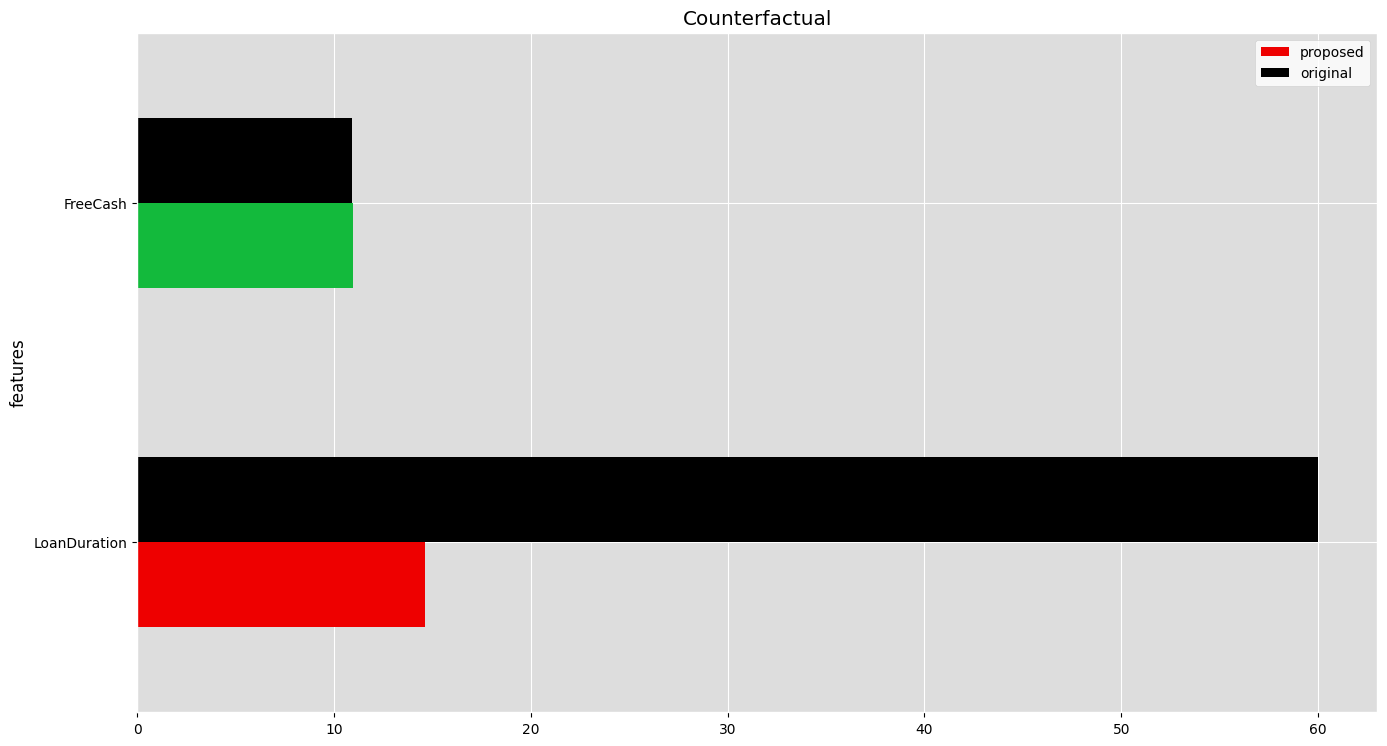

In [39]:
explanation.plot()

## Visualisation

Let's try to visualise counterfactuals in action with the following example:

We construct three clusters of data and train a model to assign points to a cluster.
Our counterfactual question can then be

> If we have a point $X$ belonging to a certain cluster $C$, how far would it need to move
> in order to belong to a desired cluster $C^'$

In [40]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=2000, n_features=2, random_state=0, centers=[(-5,0), (0, 5), (5, 0)])

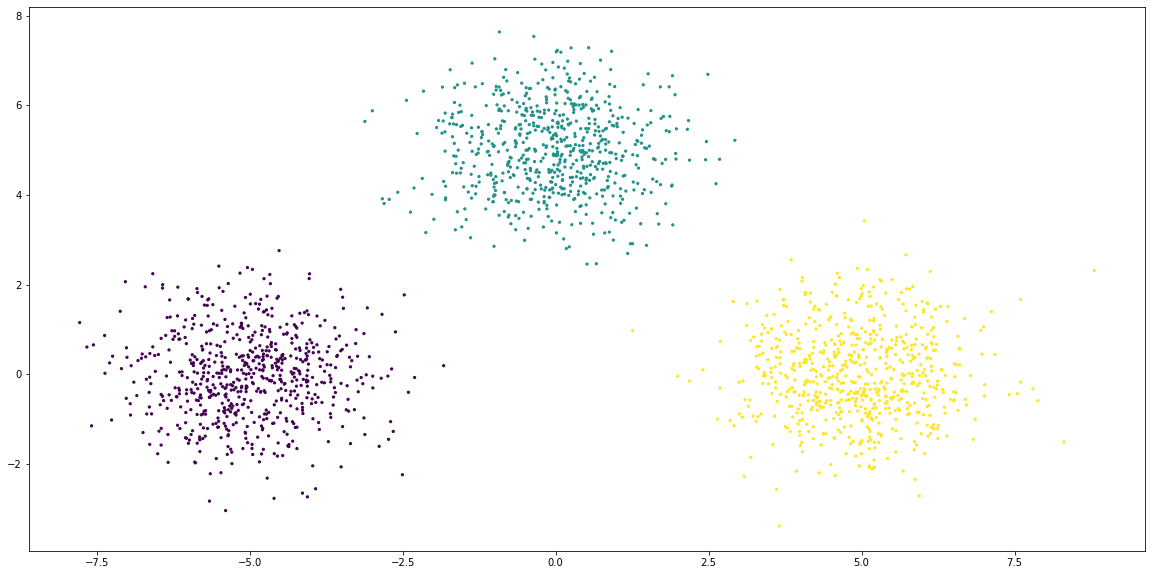

In [41]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.scatter(X[:,0], X[:,1], c=y, s=5)
plt.show()

We now train a KNN model in order to classify points and assign them to a cluster.

In [42]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X,y)

KNeighborsClassifier(n_neighbors=3)

If we take a point such as `(2.5, -1)` it is clear this point will belong to cluster `2`.

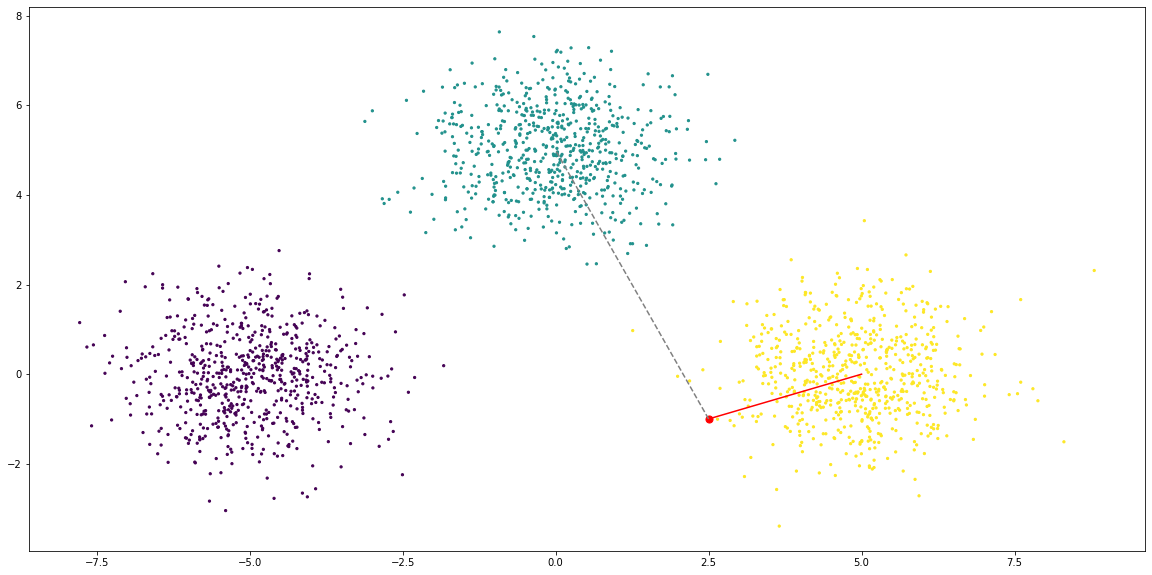

In [43]:
plt.figure(figsize=(20,10))
ORIGINAL = [2.5, -1.0]
plt.scatter(X[:,0], X[:,1], c=y, s=5)
plt.scatter(ORIGINAL[0], ORIGINAL[1], c="red", s=50)
plt.plot([ORIGINAL[0], 5], [ORIGINAL[1], 0], c="red")
plt.plot([ORIGINAL[0], 0], [ORIGINAL[1], 5], c="grey", linestyle="dashed")
plt.show()

In [44]:
import numpy as np
knn.predict_proba(np.array([[2.5, -1.0]]))

array([[0., 0., 1.]])

We can now create our prediction function. I will simply take the `x` and `y` and return the cluster classification,
along with a probability.

In [45]:
def knn_classify(inputs):
    result = knn.predict_proba(inputs)
    index = np.argmax(result, axis=1)[0]
    return np.array([index]).astype(float)

We wrap this function in the `Model` wrapper.

In [46]:
from trustyai.model import Model

knn_model = Model(knn_classify, output_names=['cluster'])

We can test it and confirm it works as expected.

We now define our goal. We want it to belong to cluster `1`.

In [47]:
goal = [output(name="cluster", dtype="number", value=1)]
features = [
    feature("x", "number", 2.5, (-10, 10)), 
    feature("y", "number", -1.0, (-10, 10))
]

We pass this data to the explainer along with the search boundaries.

In [48]:
prediction = counterfactual_prediction(
    input_features=features,
    outputs=goal,
)
explanation = explainer.explain(prediction, knn_model)

The counterfactual we get is:

In [49]:
result = explanation.proposed_features_array[0]
result

array([2.5019216 , 2.48310636])

We can confirm this point belongs to cluster `1`

In [50]:
knn_model(explanation.proposed_features_array)

array([1.])

And visually:

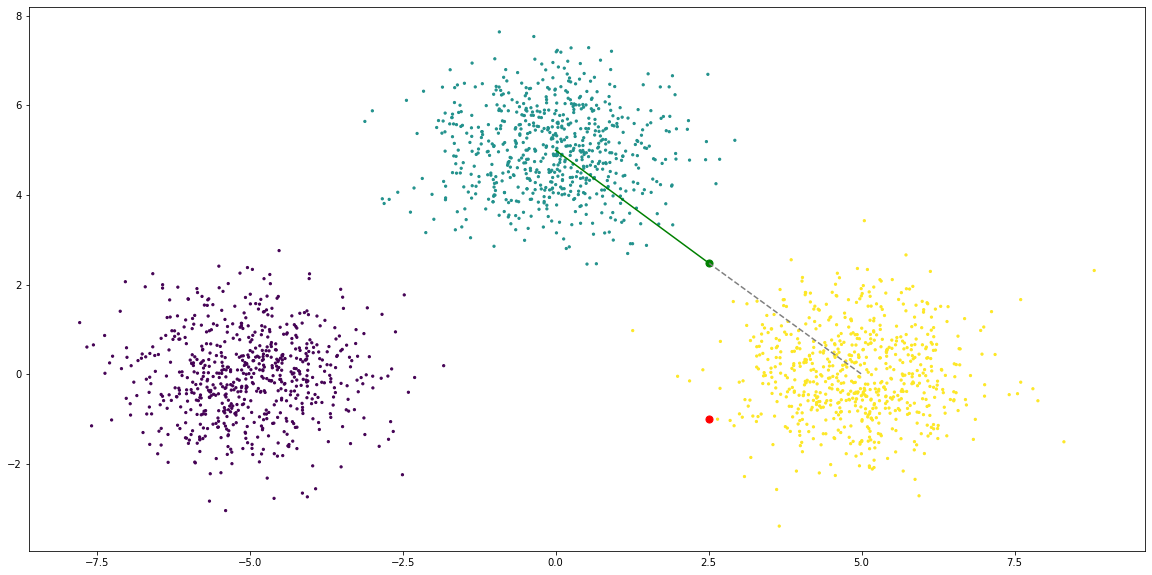

In [51]:
plt.figure(figsize=(20,10))
plt.scatter(X[:,0], X[:,1], c=y, s=5)
plt.scatter(ORIGINAL[0], ORIGINAL[1], c="red", s=50)
plt.scatter(result[0], result[1], c="green", s=50)
plt.plot([result[0], 5], [result[1], 0], c="grey", linestyle="dashed")
plt.plot([result[0], 0], [result[1], 5], c="green")

plt.show()

In [52]:
explanation.as_dataframe()

,features,proposed,original,constrained,difference
0,x,2.501922,2.5,False,0.001922
1,y,2.483106,-1.0,False,3.483106


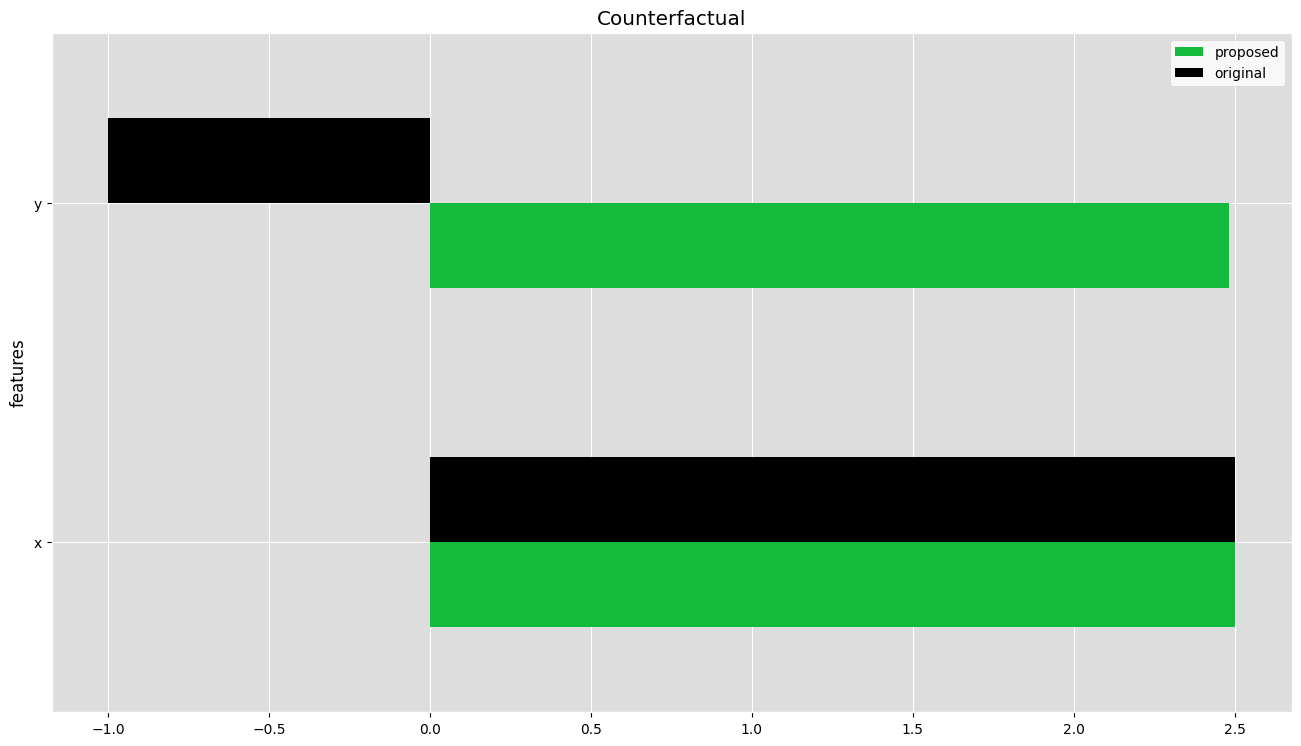

In [53]:
explanation.plot()